In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## [Competition Link](https://www.kaggle.com/competitions/dogs-vs-cats/overview)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import os
import zipfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [5]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [19]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
# Create a custom Dataset
class CatsVsDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
        
    def __len__(self):
        return len(self.image_files)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB') 
        
        label_str = self.image_files[idx].split('.')[0]
        label = 0 if label_str == 'cat' else 1 # 0 for cat, 1 for dog
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [7]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
full_dataset = CatsVsDogsDataset(root_dir='/kaggle/working/train', transform=data_transforms)

In [9]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
# Load the pre-trained model and modify it
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze the convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2) # 2 classes: cat and dog

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 192MB/s]  


In [11]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device {device}")

Using device cuda


In [17]:
num_epochs = 10 

for epoch in range(num_epochs):
    print(f"Training Epoch {epoch}")
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation
    print(f"Validating Epoch {epoch}")
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
            
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")

print("Finished Training")

Training Epoch 0


100%|██████████| 625/625 [02:02<00:00,  5.08it/s]


Validating Epoch 0


100%|██████████| 157/157 [00:27<00:00,  5.69it/s]


Epoch 1/10, Train Loss: 0.2869, Val Loss: 0.1268, Val Accuracy: 98.68%
Training Epoch 1


100%|██████████| 625/625 [02:02<00:00,  5.12it/s]


Validating Epoch 1


100%|██████████| 157/157 [00:27<00:00,  5.70it/s]


Epoch 2/10, Train Loss: 0.3849, Val Loss: 0.9816, Val Accuracy: 98.30%
Training Epoch 2


100%|██████████| 625/625 [02:02<00:00,  5.11it/s]


Validating Epoch 2


100%|██████████| 157/157 [00:27<00:00,  5.71it/s]


Epoch 3/10, Train Loss: 0.4895, Val Loss: 0.4607, Val Accuracy: 98.22%
Training Epoch 3


100%|██████████| 625/625 [02:03<00:00,  5.04it/s]


Validating Epoch 3


100%|██████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 4/10, Train Loss: 0.1635, Val Loss: 0.6153, Val Accuracy: 98.64%
Training Epoch 4


100%|██████████| 625/625 [02:02<00:00,  5.10it/s]


Validating Epoch 4


100%|██████████| 157/157 [00:27<00:00,  5.61it/s]


Epoch 5/10, Train Loss: 0.3242, Val Loss: 0.8543, Val Accuracy: 98.60%
Training Epoch 5


100%|██████████| 625/625 [02:02<00:00,  5.09it/s]


Validating Epoch 5


100%|██████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 6/10, Train Loss: 0.3379, Val Loss: 3.0018, Val Accuracy: 97.98%
Training Epoch 6


100%|██████████| 625/625 [02:03<00:00,  5.07it/s]


Validating Epoch 6


100%|██████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 7/10, Train Loss: 0.5365, Val Loss: 2.0963, Val Accuracy: 98.72%
Training Epoch 7


100%|██████████| 625/625 [02:03<00:00,  5.07it/s]


Validating Epoch 7


100%|██████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 8/10, Train Loss: 0.2004, Val Loss: 2.2398, Val Accuracy: 98.22%
Training Epoch 8


100%|██████████| 625/625 [02:03<00:00,  5.07it/s]


Validating Epoch 8


100%|██████████| 157/157 [00:28<00:00,  5.56it/s]


Epoch 9/10, Train Loss: 0.2548, Val Loss: 2.5261, Val Accuracy: 98.68%
Training Epoch 9


100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Validating Epoch 9


100%|██████████| 157/157 [00:27<00:00,  5.64it/s]

Epoch 10/10, Train Loss: 0.2707, Val Loss: 2.4829, Val Accuracy: 98.68%
Finished Training


In [20]:
model_save_path = 'dogs_vs_cats_vgg16_finetuned.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to dogs_vs_cats_vgg16_finetuned.pth


In [21]:
def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    original_image = image.copy() # Keep original for display
    image = transform(image).unsqueeze(0) # Add batch dimension
    image = image.to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        
    class_label = 'Dog' if predicted.item() == 1 else 'Cat'
    return class_label, original_image


Visualizing a few predictions from the validation set:


NameError: name 'image_path' is not defined

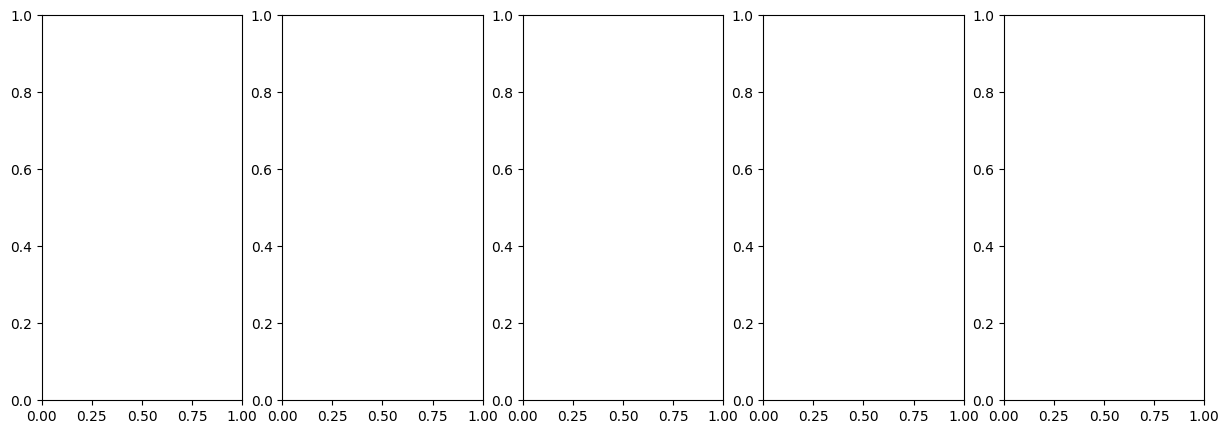

In [28]:
print("\nVisualizing a few predictions from the validation set:")

num_images_to_show = 5
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))
axes = axes.flatten()
random_indices = torch.randperm(len(val_dataset))[:num_images_to_show]
for i, idx in enumerate(random_indices):
    tensor_image, true_label_idx = val_dataset[idx] # Accessing via val_dataset to get correct subset
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    display_image = tensor_image.cpu().numpy().transpose((1, 2, 0))
    display_image = std * display_image + mean
    display_image = np.clip(display_image, 0, 1) # Clip values to [0, 1]
    predicted_class, original_pil_image = predict_image(image_path, model, data_transforms, device)
    true_class = 'Dog' if true_label_idx == 1 else 'Cat'

    axes[i].imshow(original_pil_image)
    axes[i].set_title(f"True: {true_class}\nPred: {predicted_class}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()